Begun 1/14/25

This notebook is to double-check whether the code for calculating the filtering transfer function gives the factor $t_b^{2}$ from Steve's PS paper or just $t_b$. I think it is $t_b^{2}$, which would mean that the correction to the number of modes would have to be the square root of that.

I'd also like to check that the bincount factor we get from our power spectra is equal to (2$\ell$+1)(bin_size)(f_sky without the w2 factor), as I believe it should be if we ignore the w2 factor and the filtering transfer function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import nawrapper as nw
import yaml
import time
import healpy as hp

In [2]:
# Loading in CAMB input spectra
ell_camb,DlTT_camb,DlEE_camb,DlBB_camb,DlTE_camb = np.loadtxt( \
            "/home/zbh5/act_analysis/act_axion_analysis/resources/camb_19413797_lensedtotcls.dat", \
                                                              usecols=(0,1,2,3,4), unpack=True) 
# Note that ell_camb runs from 2 to 5400
# Healpy expects ell to start at zero
# Initializing new arrays with first two entries set to zero
arr_len = ell_camb.size+2
ell = np.zeros(arr_len)
ell[1] = 1
ell[2:] = ell_camb
ClTT = np.zeros(arr_len)
ClEE = np.zeros(arr_len)
ClTE = np.zeros(arr_len)
ClBB = np.zeros(arr_len)
# convert Dl to Cl
ClTT[2:] = DlTT_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClEE[2:] = DlEE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClTE[2:] = DlTE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClBB[2:] = DlBB_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))

In [6]:
keys_eshow = {"downgrade": 4, "ticks": 5, "colorbar": True, "font_size": 40}

def eshow(x,**kwargs): 
    ''' Function to plot the maps for debugging '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "auto")

# Functions for calculating power spectra from depth-1 and reference map to use as noise in sims
# Confirmed that these match what is in axion_osc_analysis_depth1_ps.py on 12/3/24
def make_tapered_mask(map_to_mask,filter_radius=1.0,plot=False):
    """
        Makes a mask for a given map based on where the ivar map is nonzero.
        Also apodizes the mask and gets the indices of where the apodized
        mask is not equal to one (everything tapered or outside the mask)
        in order to set all points but those to zero after filtering.
    """
    footprint = 1*map_to_mask.astype(bool)
    mask = nw.apod_C2(footprint,filter_radius)
    
    # Getting points to set to zero after filtering
    indices = np.nonzero(mask != 1)
    
    if plot:
        eshow(mask, **keys_eshow)
    
    return mask, indices

def spectrum_from_maps(map1, map2, b_ell_bin_1, b_ell_bin_2, w2, bins):
    """Function modified from the one in ACT DR4/5 NB7 for binning a power spectrum for two maps.
       This function does account for a window correction for the apodizing at this point.
       Also accounts for a beam correction using a beam defined by b_ell.
    """
    spectrum = np.real(map1*np.conj(map2))

    # Dividing by an approx. correction for the loss of power from tapering
    spectrum /= w2

    modlmap = map1.modlmap()

    # Bin the power spectrum
    digitized = np.digitize(np.ndarray.flatten(modlmap), bins, right=True)
    bincount = np.bincount(digitized)[1:-1]
    binned = np.bincount(digitized, spectrum.reshape(-1))[1:-1]/bincount

    binned /= (b_ell_bin_1*b_ell_bin_2)

    return binned, bincount

def get_hivon_fsky_enmap_no_w2(mask):
    imap = mask/np.max(mask)
    w2w4 = (np.mean(imap**2.)**2./np.mean(imap**4.))
    skyarea = imap.area()/(4.*np.pi)
    return skyarea

def apply_kspace_filter(maps, kx_cut, ky_cut, unpixwin):
    """
        Takes in a set of T/Q/U maps that already have a taper applied, apply
        a k-space filter to remove ground pickup, and returns the E and B maps

        Adjusted later to work for filtering a single T map too.
    """
    singleobs_TEB = enmap.map2harm(maps, normalize = "phys")

    if unpixwin:  # remove pixel window in Fourier space
        if len(singleobs_TEB.shape) == 3: # if there is a third index for multiple maps
            for i in range(len(singleobs_TEB)):
                wy, wx = enmap.calc_window(singleobs_TEB[i].shape)
                singleobs_TEB[i] /= wy[:, np.newaxis]
                singleobs_TEB[i] /= wx[np.newaxis, :]
        else:
            wy, wx = enmap.calc_window(singleobs_TEB.shape)
            singleobs_TEB /= wy[:, np.newaxis]
            singleobs_TEB /= wx[np.newaxis, :]

    ly, lx = singleobs_TEB.lmap()
    kfilter_x = np.abs(lx) >= kx_cut
    kfilter_y = np.abs(ly) >= ky_cut
    filtered_TEB = singleobs_TEB * kfilter_x * kfilter_y

    return filtered_TEB

In [4]:
# Generating test pixell map in same shape as a depth-1 map
# Grabbing our new list with more maps in case I want to test more of the ones that fail the PTE test
obs_list = "/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/dr6_depth1_test_map_w_second_batch_list.txt"
with open(obs_list) as f:
    lines = f.read().splitlines()

In [37]:
# Just need to calculate a spectrum to test bincount - doesn't matter which

indices = [0] # which depth-1 maps to use - testing a single map first
for idx in indices:
    depth1_path = '/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/' + lines[idx]
    depth1_maps = enmap.read_map(depth1_path)
    ivar_path = depth1_path[:-8] + "ivar.fits"
    depth1_ivar = 0.5*enmap.read_map(ivar_path) # 0.5 for E noise
    depth1_mask, depth1_indices = make_tapered_mask(depth1_ivar,filter_radius=1.0,plot=False)
    
    #eshow(depth1_T, **keys_eshow)
    #eshow(depth1_mask, **keys_eshow)
    
    w2 = np.mean(depth1_mask**2)
    w2w4 = np.mean(depth1_mask**2)**2 / np.mean(depth1_mask**4)
    
    #N_sims = 5000
    lmin = 50
    lmax = 1001
    bin_size = 25
    kx_cut = 90
    ky_cut = 50
    unpixwin=True
    
    bins = np.arange(lmin, lmax, bin_size)
    centers = (bins[1:] + bins[:-1])/2.0
    
    filtered_depth1_TEB = apply_kspace_filter(depth1_maps*depth1_mask, kx_cut, ky_cut, unpixwin=unpixwin)
    
    binned_EE, bincount = spectrum_from_maps(filtered_depth1_TEB[1], filtered_depth1_TEB[1], \
                                             b_ell_bin_1=1.0, b_ell_bin_2=1.0, w2=w2, bins=bins)
    
    f_sky = get_hivon_fsky_enmap_no_w2(depth1_mask)

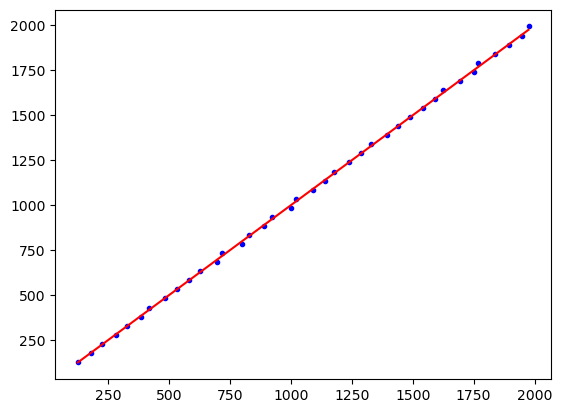

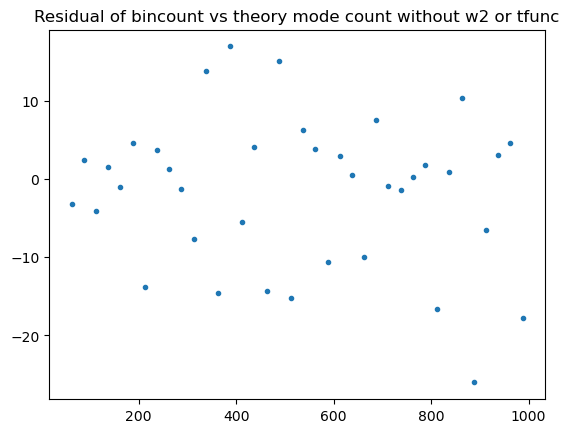

In [38]:
theory_modes_no_w2 = (2*centers+1)*bin_size*f_sky
plt.plot(bincount,theory_modes_no_w2,'b.')
plt.plot(np.arange(np.min(bincount),np.max(bincount)),np.arange(np.min(bincount),np.max(bincount)),'r')
plt.show()
plt.close()
plt.plot(centers,bincount-theory_modes_no_w2,'.')
plt.title("Residual of bincount vs theory mode count without w2 or tfunc")
plt.show()
plt.close()

In [39]:
# Checking what is returned by this function
def get_tfunc(kx, ky, bins, lmax=5000):
    """Calculating transfer function for filtering with cutoffs kx and ky.
       lmax just needs to be higher than the range we want to measure since
       the bins will appropriately handle excluding higher ells."""
    cut = (ky+kx)*4
    ell = np.arange(lmax)
    tfunc = np.zeros(lmax)
    tfunc[1:] = 1 - cut / (2*np.pi*ell[1:])

    digitized = np.digitize(ell, bins, right=True)
    bincount = np.bincount(digitized)[1:-1]
    tfunc_binned = np.bincount(digitized, tfunc.reshape(-1))[1:-1]/bincount
    return tfunc_binned

In [40]:
tfunc = get_tfunc(kx_cut,ky_cut,bins)

/tmp/ipykernel_57046/1919733974.py:2: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(centers,np.sqrt(tfunc),label='sqrt')


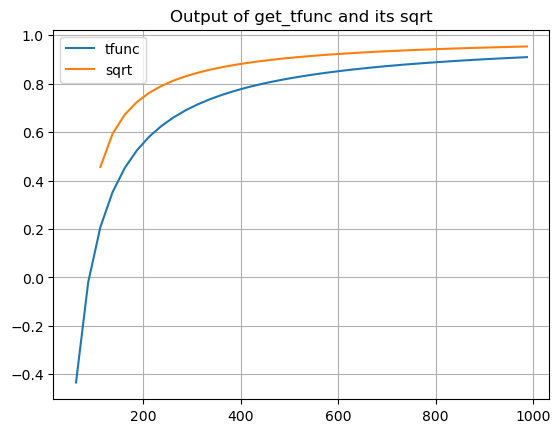

In [42]:
plt.plot(centers,tfunc,label='tfunc')
plt.plot(centers,np.sqrt(tfunc),label='sqrt')
plt.title("Output of get_tfunc and its sqrt")
plt.legend()
plt.grid()
plt.show()
plt.close()

It does appear that bincount = (2$\ell$+1)(bin_size)(f_sky w/o w2) and that the thing plotted in Fig. 4 of Steve's paper is $t_b^2$ from Steve's paper after plotting it for a variety of bin sizes and ell ranges. This means that we need the square root of that for the correction to the number of modes (comparing Eq. 9 to the text under Eq. 1).